# Predicting loan charge-off

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.plotting import plot_lifetimes
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [57]:
sns.set_theme(style='whitegrid')

In [58]:
loan_df = pd.read_csv('loan_timing.csv')
loan_df.head(20)

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN
5,158,NaN
6,302,NaN
7,143,NaN
8,354,NaN
9,438,NaN


### Data exploration and cleaning

In [59]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   days since origination              50000 non-null  int64  
 1   days from origination to chargeoff  3305 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 781.4 KB


In [60]:
loan_df.describe()

,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


In [61]:
loan_df.isnull().sum()

days since origination                    0
days from origination to chargeoff    46695
dtype: int64

#### Separation of loans that have already charged off to those that have not yet (current loans)

In [62]:
charged_off_loans = loan_df[loan_df['days from origination to chargeoff'].notna()]
charged_off_loans.shape

(3305, 2)

In [63]:
current_loans = loan_df[loan_df['days from origination to chargeoff'].isna()]
current_loans = current_loans['days since origination']
current_loans.shape

(46695,)

### Exploratory plots 

Text(0.5, 1.0, 'Histogram of days since origination for loans that have not charged off (current loans)')

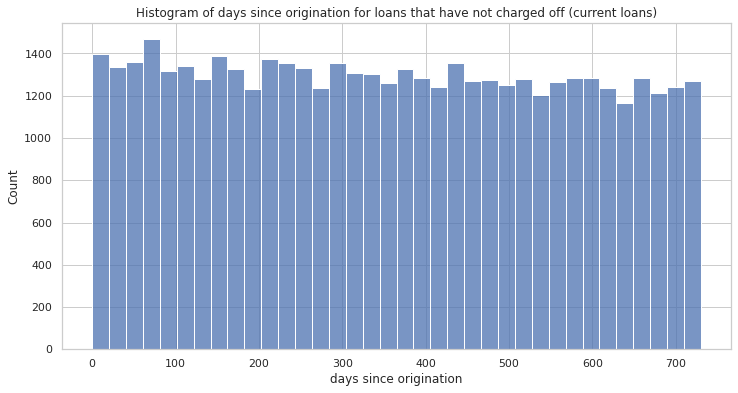

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.histplot(
    data=current_loans
)
ax.set_title('Histogram of days since origination for loans that have not charged off (current loans)')

Text(0.5, 1.0, 'Histogram of days since origination and days to charge off for loans that have charged off')

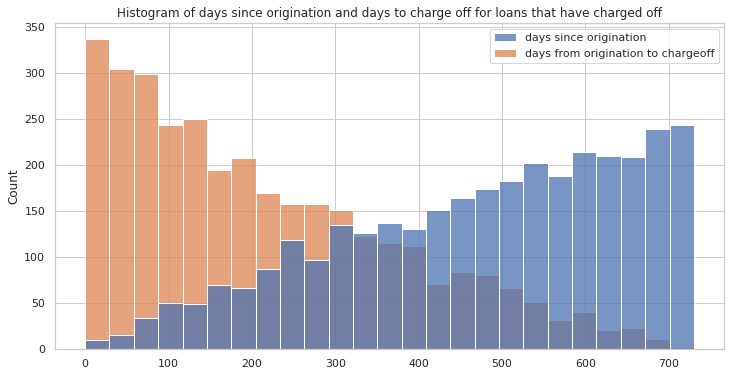

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.histplot(
    data=charged_off_loans,
    bins=25
)
ax.set_title('Histogram of days since origination and days to charge off for loans that have charged off')

Observations from the above plot:<br>
- From the `days from origination to charge-off` graph (represented in `orange`), we can see that the number of charged-off loans decreases as the `number of days from origination to charge-off` increases.
From this we can assume that newer loans are more likely to be charged off.

- From the number of days shown on the x-axis, we can see that 700 is the highest number of days. That shows us that most loans are charged off within about two years form the date of origination.



### Choice of approach for predicting charge-off
Since the problem set above involves a predicition of duration, `Survival Analysis` is one of the best choices to approach it.

### Survival analysis

#### Brief background

Survival Analysis is a set of statistical tools, which addresses questions like `How long would it be before a particular event occurs?`.<br>
In other words, it as a `time to event` analysis.<br>
This technique was primarily developed by medical researchers and they were more interested in finding expected lifetime of patients in different cohorts (ex: Cohort 1- treated with Drug A, & Cohort 2- treated with Drug B).<br>
This analysis can be further applied to not just traditional death events, but to many different types of events of interest in different business domains.

#### Application to the `loan charge-off` problem

In [66]:
# Creation of a 'censored' column that shows whether a loan is censored i.e has not yet charged off and therefore we do not know when it will charge off (0 if we know when it charged off and 1 if we do not)
loan_df['censored'] = loan_df['days from origination to chargeoff'].apply(lambda x: 0 if x else 1)
loan_df.fillna(0, inplace=True)
loan_df['days from origination to chargeoff'] = loan_df['days from origination to chargeoff'].astype(int)
loan_df.head(20)

,days since origination,days from origination to chargeoff,censored
0,109,0,0
1,679,0,0
2,723,0,0
3,509,0,0
4,254,0,0
5,158,0,0
6,302,0,0
7,143,0,0
8,354,0,0
9,438,0,0


#### Kaplan Meier Estimator
In this survival analysis, we will be using the The `Kaplan–Meier estimator`, also known as the `product limit estimator`. It is a non-parametric statistic used to estimate the survival function from lifetime data.


For the first trial, we will apply the `Kaplan–Meier estimator` on all the loans at once

In [67]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = loan_df['days since origination'] # timeline/durations
E = loan_df['censored'] # boolean array representing whether the loan charged off before the data collection
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50000 total observations, 49984 right-censored observations>

Text(0.5, 0, 'Timeline (in days)')

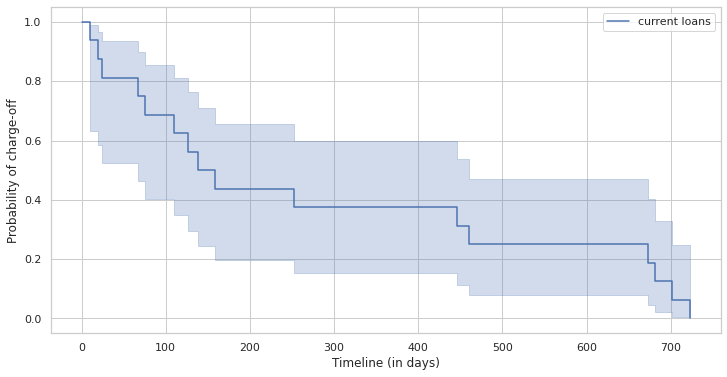

In [55]:
ax = kmf.plot_survival_function()
ax.set_ylabel('Probability of charge-off')
ax.set_xlabel('Timeline (in days)')

Below, we also apply the `Kaplan–Meier estimator` on the loans separated into groups of those that charged off and those that are still current. This gives us an even more detailed analysis.

Text(0.5, 0, 'Timeline (in days)')

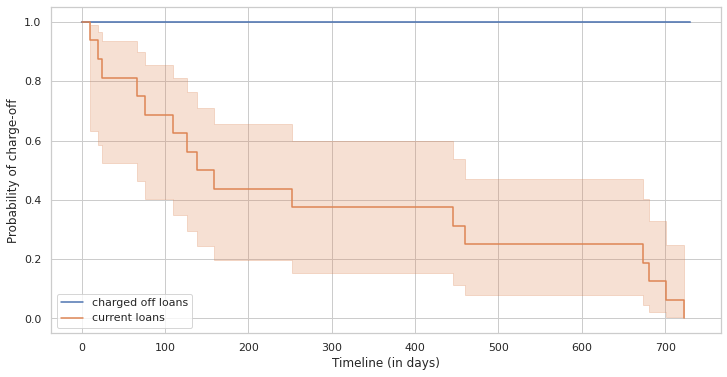

In [68]:
groups = loan_df['censored']
ix = (groups == 1)

kmf.fit(T[~ix], E[~ix], label='charged off loans')
ax = kmf.plot_survival_function()

kmf.fit(T[ix], E[ix], label='current loans')
ax = kmf.plot_survival_function(ax=ax)

ax.set_ylabel('Probability of charge-off')
ax.set_xlabel('Timeline (in days)')

### Findings

On the above graph, the red curve represents the estimations for loans that are current (have not yet charged off). We can see that loans that originated `100` or less days ago have about `70%` and above probability of charging off.<br>
Below, we pick out these loans and count how many they are. From that, we can calculate their fraction/percentage of the whole dataset.

In [69]:
high_chance_of_chargeoff_count = loan_df[loan_df['days since origination'] <= 100].count()[0]
high_chance_of_chargeoff_percentage = high_chance_of_chargeoff_count/current_loans.shape[0] * 100
high_chance_of_chargeoff_percentage

14.770318021201415

### Conclusion

We can conclude that about `14.77%` of the loans will have charged off by the time all of their 3-year terms are finished